In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

sns.set_context('talk')
sns.set_style("whitegrid")
sns.set_palette("colorblind")

import copy
from hendrics.fake import filter_for_deadtime
from stingray import Powerspectrum, Crossspectrum, AveragedPowerspectrum


import numpy as np
import scipy.stats
import scipy.special
import scipy.fftpack

from stingray.utils import rebin_data

np.random.seed(348172694)

from stingray import Lightcurve, Crossspectrum
from stingray.simulator.simulator import Simulator
from scipy.ndimage.filters import gaussian_filter1d


np.random.seed(1209432)

# Fourier amplitudes with correlated noise


Here we show that the difference of Fourier amplitudes is independent of frequency, and independent on the presence of correlated noise.

In [2]:
time = np.arange(0, 100000, 0.50)

sim = Simulator(N=len(time), dt=0.125, rms=0.5, mean=1000)
sim_lc = sim.simulate(1.)
stochastic = sim_lc.counts
if np.any(stochastic < 0):
    stochastic += 100 - np.min(stochastic)
# plt.figure()
# plt.plot(time, stochastic, zorder=3, )
# plt.xlabel('Time')
# plt.ylabel('Counts')


<IPython.core.display.Javascript object>


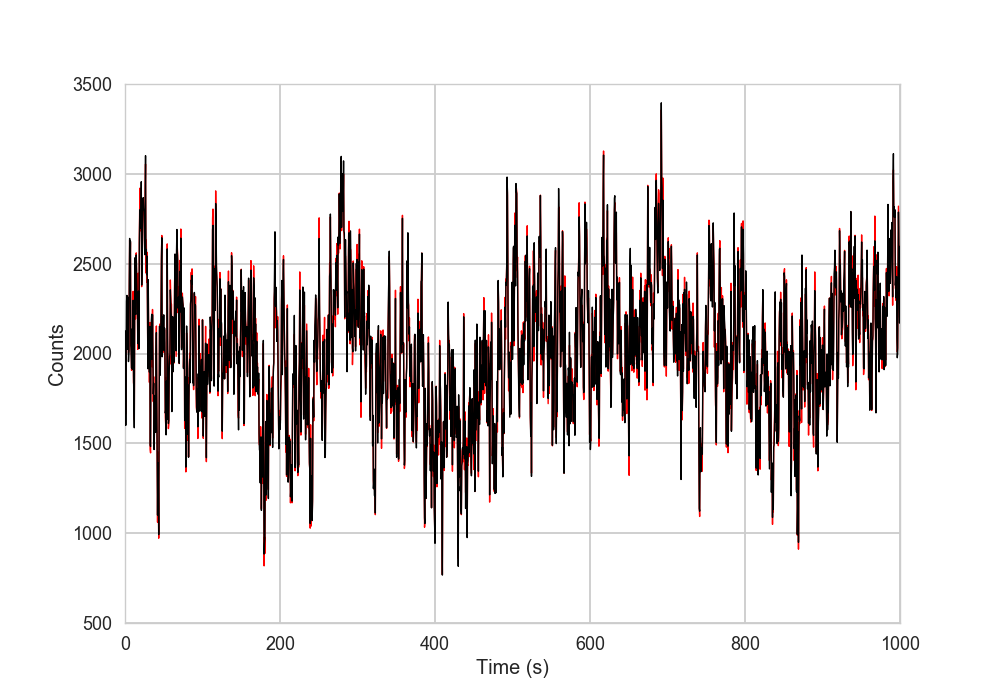

In [3]:
counts1 = np.random.poisson(stochastic)  
counts2 = np.random.poisson(stochastic)  

lc1 = Lightcurve(time, counts1)
lc2 = Lightcurve(time, counts2)

plt.figure(figsize=(10, 7))
plt.plot(lc1.time, stochastic, zorder=3,lw=1, color='k')

plt.plot(lc1.time, lc1.counts, lw=1, color='r')
plt.xlim([0, 1000])
plt.ylim([500, 3500])
plt.xlabel('Time (s)')
plt.ylabel('Counts')
plt.savefig('lightcurve')

<IPython.core.display.Javascript object>


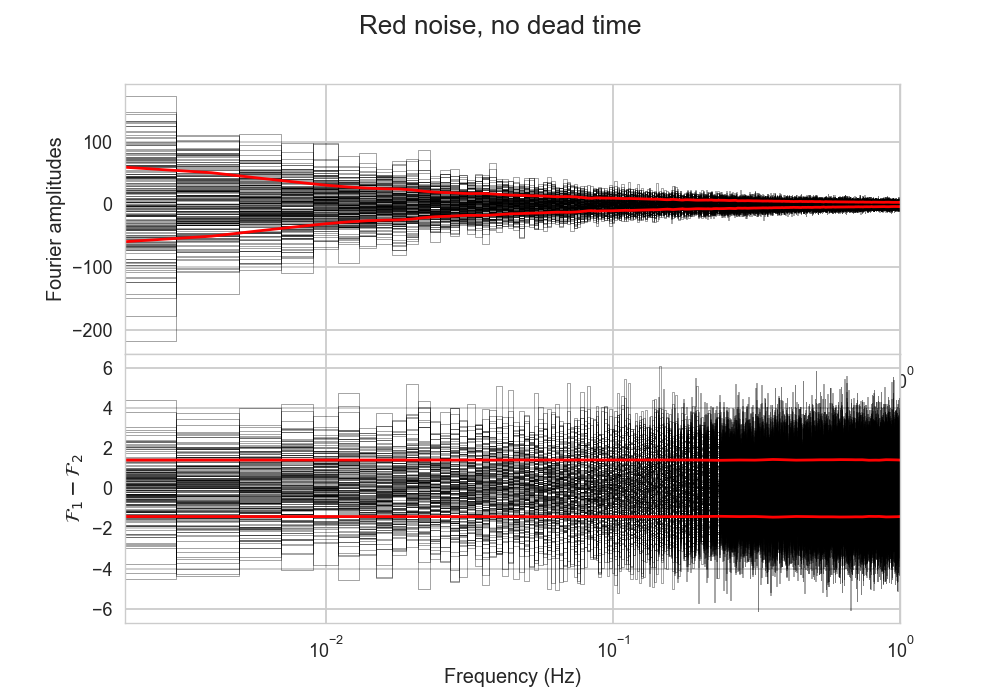

In [4]:
plt.figure(figsize=(10, 7))
plt.suptitle("Red noise, no dead time")
gs = GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

fourier_all = []
diff_all = []
for start_time in np.arange(lc1.time[0], lc1.time[-1], 500):
    good = (lc1.time > start_time)&(lc1.time < start_time + 500)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]
    
    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
    freqs = freqs[freqs > 0]

    ax0.plot(freqs, fourier1.real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, fourier2.real, drawstyle='steps-mid', color='r', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, gaussian_filter1d(np.sqrt(fourier2 * fourier1.conj()).real, 10), lw=1)
    ax0.semilogx()
    fourier_all.append(fourier1.real)
    
    ax1.plot(freqs, (fourier1 - fourier2).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    diff_all.append((fourier1 - fourier2).real)

fourier_all = np.array(fourier_all)
diff_all = np.array(diff_all)

ax0.plot(freqs, gaussian_filter1d(np.std(fourier_all, axis=0), 1), lw=2, color='r')
ax0.plot(freqs, -gaussian_filter1d(np.std(fourier_all, axis=0), 1),  lw=2, color='r')
ax0.set_ylabel('Fourier amplitudes')

ax1.plot(freqs, gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.plot(freqs, -gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.set_ylabel('$\mathcal{F}_1 - \mathcal{F}_2$')


ax1.set_xlabel('Frequency (Hz)')
ax0.set_xlim(freqs[0], freqs[-1])

plt.savefig('rn_fourierdiff.jpg')


## And if the flux is a little different?


In [5]:
time = np.arange(0, 100000, 0.50)

sim = Simulator(N=len(time), dt=0.125, rms=0.5, mean=1000)
sim_lc = sim.simulate(1.)
stochastic = sim_lc.counts
if np.any(stochastic < 0):
    stochastic += 100 - np.min(stochastic)

In [6]:
counts1 = np.random.poisson(stochastic)  
counts2 = np.random.poisson(stochastic) * 0.9

lc1 = Lightcurve(time, counts1)
lc2 = Lightcurve(time, counts2)

<IPython.core.display.Javascript object>


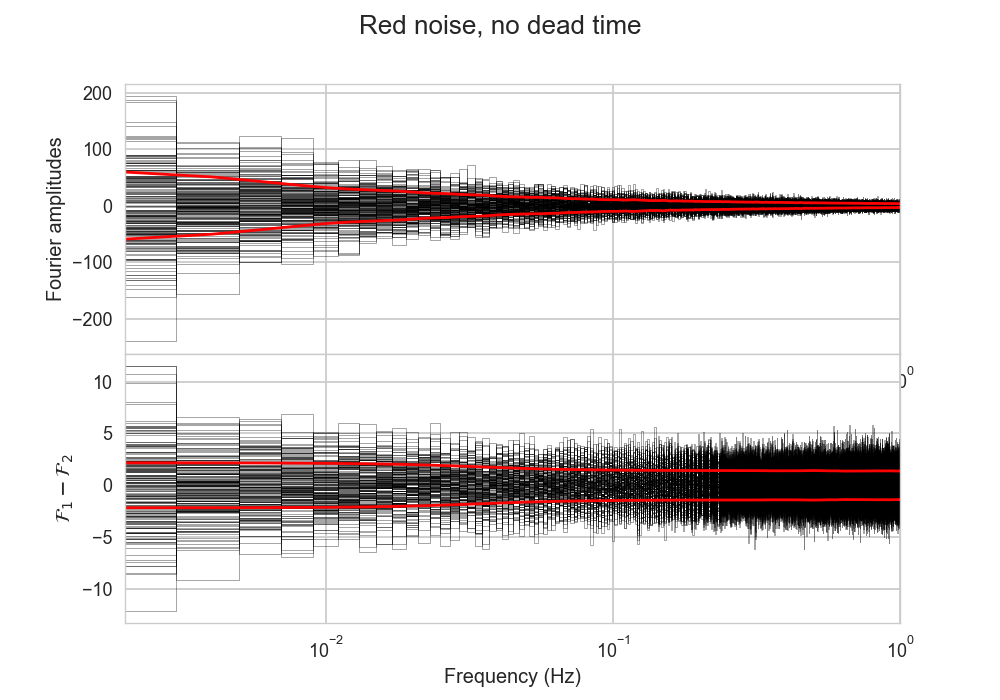

In [7]:
plt.figure(figsize=(10, 7))
plt.suptitle("Red noise, no dead time")
gs = GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

fourier_all = []
diff_all = []
for start_time in np.arange(lc1.time[0], lc1.time[-1], 500):
    good = (lc1.time > start_time)&(lc1.time < start_time + 500)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]
    
    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
    freqs = freqs[freqs > 0]

    ax0.plot(freqs, fourier1.real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, fourier2.real, drawstyle='steps-mid', color='r', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, gaussian_filter1d(np.sqrt(fourier2 * fourier1.conj()).real, 10), lw=1)
    ax0.semilogx()
    fourier_all.append(fourier1.real)
    
    ax1.plot(freqs, (fourier1 - fourier2).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    diff_all.append((fourier1 - fourier2).real)

fourier_all = np.array(fourier_all)
diff_all = np.array(diff_all)

ax0.plot(freqs, gaussian_filter1d(np.std(fourier_all, axis=0), 1), lw=2, color='r')
ax0.plot(freqs, -gaussian_filter1d(np.std(fourier_all, axis=0), 1),  lw=2, color='r')
ax0.set_ylabel('Fourier amplitudes')

ax1.plot(freqs, gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.plot(freqs, -gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.set_ylabel('$\mathcal{F}_1 - \mathcal{F}_2$')

ax1.set_xlabel('Frequency (Hz)')
ax0.set_xlim(freqs[0], freqs[-1])

plt.savefig('rn_fourierdiff_diffflux.jpg')



Try to correct the lightcurve by multiplying by the mean flux ratio

<IPython.core.display.Javascript object>


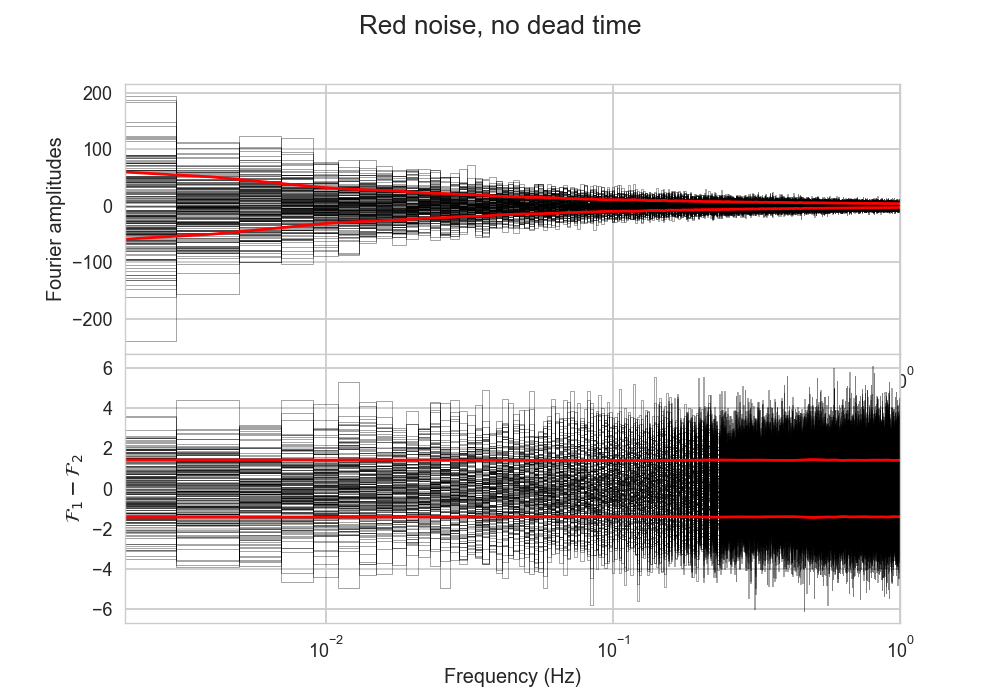

In [8]:
plt.figure(figsize=(10, 7))
plt.suptitle("Red noise, no dead time")
gs = GridSpec(2, 1, hspace=0)
ax0 = plt.subplot(gs[0])
ax1 = plt.subplot(gs[1], sharex=ax0)

fourier_all = []
diff_all = []
for start_time in np.arange(lc1.time[0], lc1.time[-1], 500):
    good = (lc1.time > start_time)&(lc1.time < start_time + 500)
    good_counts1 = lc1.counts[good]
    good_counts2 = lc2.counts[good]
    mean1 = np.mean(good_counts1)
    mean2 = np.mean(good_counts2)
    good_counts2 *= mean1 / mean2
    
    fourier1 = scipy.fftpack.fft(good_counts1)
    fourier2 = scipy.fftpack.fft(good_counts2)

    freqs = scipy.fftpack.fftfreq(len(good_counts1), lc1.dt)

    fourier1 = fourier1[freqs>0] * np.sqrt(2 / np.sum(good_counts1))
    fourier2 = fourier2[freqs>0] * np.sqrt(2 / np.sum(good_counts2))
    freqs = freqs[freqs > 0]

    ax0.plot(freqs, fourier1.real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, fourier2.real, drawstyle='steps-mid', color='r', alpha=0.5, lw=0.5)
#     ax0.plot(freqs, gaussian_filter1d(np.sqrt(fourier2 * fourier1.conj()).real, 10), lw=1)
    ax0.semilogx()
    fourier_all.append(fourier1.real)
    
    ax1.plot(freqs, (fourier1 - fourier2).real, drawstyle='steps-mid', color='k', alpha=0.5, lw=0.5)
    diff_all.append((fourier1 - fourier2).real)

fourier_all = np.array(fourier_all)
diff_all = np.array(diff_all)

ax0.plot(freqs, gaussian_filter1d(np.std(fourier_all, axis=0), 1), lw=2, color='r')
ax0.plot(freqs, -gaussian_filter1d(np.std(fourier_all, axis=0), 1),  lw=2, color='r')
ax0.set_ylabel('Fourier amplitudes')

ax1.plot(freqs, gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.plot(freqs, -gaussian_filter1d(np.std(diff_all, axis=0), 10), lw=2, color='r')
ax1.set_ylabel('$\mathcal{F}_1 - \mathcal{F}_2$')

ax1.set_xlabel('Frequency (Hz)')
ax0.set_xlim(freqs[0], freqs[-1])

plt.savefig('rn_fourierdiff_diffflux.jpg')




Ok, it seems that the fourier difference has become stable enough again